<a href="https://colab.research.google.com/github/LuisPerdomo123/Inteligencia-Computacional/blob/main/Classification_MLP_Caso_Practico_II.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clasidicación MLP - Caso Práctico II

## Conjunto de datos: Detección de trasacciones bancarias fraudulentas

### Descripción
The datasets contains transactions made by credit cards in September 2013 by european cardholders. This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions.The dataset is highly unbalanced, the positive class (frauds) account for 0.172 % of all transactions.

It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we connot provide the original features and more background information about the data. Features V1, V2, ... V28 are the principal componets obtained with PCA, the only features which have not been transformed with PCA are 'Time' contains the seconds elapsed between each transaction and 'Amount'. Feature 'Time' contains the second elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-senstive learning. Feature 'Class' is the response variable and takes value 1 in case of fraud and 0 otherwise.

### Descarga de los ficheros de datos

https://www.kaggle.com/mlg-ulb/creditcardfraud#creditcard.csv

### Referencias adicionales sobre el conjunto de datos
The dataset has been collected and analysed during research collaboration of Worldline and th Machine Learning Group (http://mlg.ulb.ac.be) of OLB (Université Libre de Bruxelles) on big data mining and fraud detection. More details on current and past projects on related topics are available on https://www.researchgate.net/project/Fraud-detection-5 and the page of the DefeatFraud project.

## Imports

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.gridspec as gridspec
from collections import Counter
from sklearn import metrics
import numpy as np
from sklearn.model_selection import train_test_split
from matplotlib.colors import LogNorm
from sklearn.metrics import f1_score

## Funciones auxiliares

In [18]:
# Construcción de una función que realice el particionado completo
def train_val_test_split(df, rstate=42, shuffle=True, stratify=None):
  start = df[stratify] if stratify else None
  train_set, test_set = train_test_split(
      df, test_size=0.4, random_state=rstate, shuffle=shuffle, stratify=start)
  start = test_set[stratify] if stratify else None
  val_set, test_set = train_test_split(
      test_set, test_size=0.5, random_state=rstate, shuffle=shuffle, stratify=start)
  return (train_set, val_set, test_set)

In [19]:
def remove_labels(df, label_name):
  X = df.drop(label_name, axis=1)
  y = df[label_name].copy()
  return (X, y)

## 1. Lectura del conjunto de datos

In [6]:
from google.colab import files
import pandas as pd

# Selecciona el archivo CSV desde tu sistema local
uploaded = files.upload()

# Lee el archivo CSV cargado
for fn in uploaded.keys():
  print('Archivo cargado: "{name}" con tamaño {length} bytes'.format(name=fn, length=len(uploaded[fn])))

# Lee el archivo CSV y carga los datos en un DataFrame de pandas
df = pd.read_csv(next(iter(uploaded)))

Saving creditcard.csv to creditcard.csv
Archivo cargado: "creditcard.csv" con tamaño 150828752 bytes


## 2. Visualización del conjunto de datos

In [7]:
df.head(10)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
5,2.0,-0.425966,0.960523,1.141109,-0.168252,0.420987,-0.029728,0.476201,0.260314,-0.568671,...,-0.208254,-0.559825,-0.026398,-0.371427,-0.232794,0.105915,0.253844,0.081080,3.67,0
6,4.0,1.229658,0.141004,0.045371,1.202613,0.191881,0.272708,-0.005159,0.081213,0.464960,...,-0.167716,-0.270710,-0.154104,-0.780055,0.750137,-0.257237,0.034507,0.005168,4.99,0
7,7.0,-0.644269,1.417964,1.074380,-0.492199,0.948934,0.428118,1.120631,-3.807864,0.615375,...,1.943465,-1.015455,0.057504,-0.649709,-0.415267,-0.051634,-1.206921,-1.085339,40.80,0
8,7.0,-0.894286,0.286157,-0.113192,-0.271526,2.669599,3.721818,0.370145,0.851084,-0.392048,...,-0.073425,-0.268092,-0.204233,1.011592,0.373205,-0.384157,0.011747,0.142404,93.20,0
9,9.0,-0.338262,1.119593,1.044367,-0.222187,0.499361,-0.246761,0.651583,0.069539,-0.736727,...,-0.246914,-0.633753,-0.120794,-0.385050,-0.069733,0.094199,0.246219,0.083076,3.68,0


In [8]:
print("Número de características:", len(df.columns))
print("Longitud del conjunto de datos:", len(df))

Número de características: 31
Longitud del conjunto de datos: 284807


In [9]:
# 492 transacciones fraudulentas, 284315 transacciones legitimas
# El conjnto de datos se encuentra desequilibrado
df["Class"].value_counts()

0    284315
1       492
Name: Class, dtype: int64

In [10]:
# Visualizamos los tipos de cada uno de los atributos
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [11]:
# Comprobamos si alguna columna tiene valores nulos
df.isna().any()

Time      False
V1        False
V2        False
V3        False
V4        False
V5        False
V6        False
V7        False
V8        False
V9        False
V10       False
V11       False
V12       False
V13       False
V14       False
V15       False
V16       False
V17       False
V18       False
V19       False
V20       False
V21       False
V22       False
V23       False
V24       False
V25       False
V26       False
V27       False
V28       False
Amount    False
Class     False
dtype: bool

In [12]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


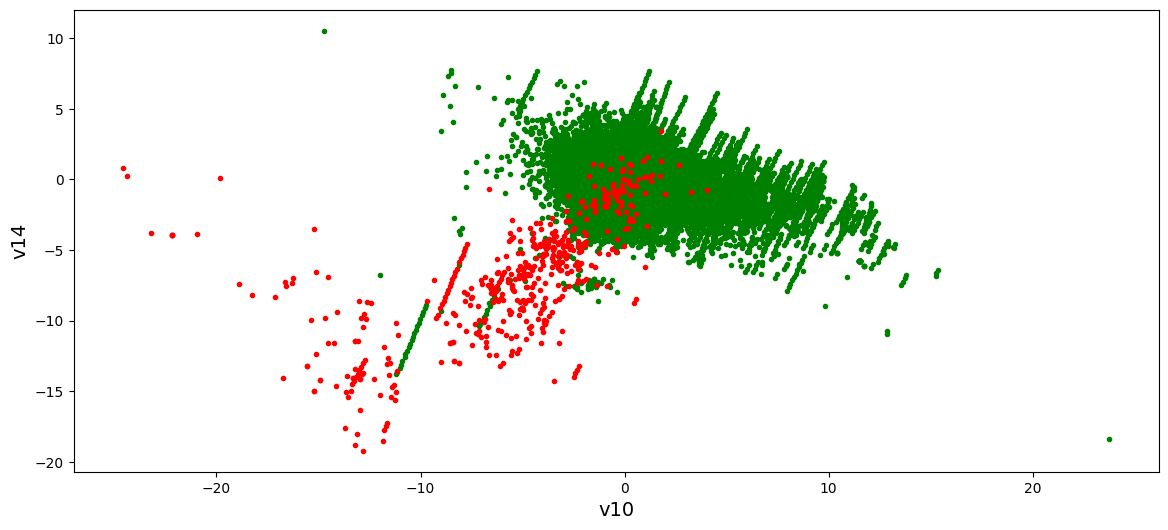

In [23]:
# Representación gráfica de dos características
plt.figure(figsize=(14,6))
plt.scatter(df["V10"][df['Class'] == 0], df["V14"][df['Class']==0], c="g", marker=".")
plt.scatter(df["V10"][df['Class'] == 1], df["V14"][df['Class']==1], c="r", marker=".")
plt.xlabel("v10", fontsize=14)
plt.ylabel("v14", fontsize=14)
plt.show()

## 3. Preparación del conjunto de datos

Para este tipo de algoritmos es importante que todos los datos se encuentren en un rango similar por lo tanto, podemos aplicar una función de escalado o normalización. Otra opción, es eliminar las características que no se encuentran en un rango similar siempre y cuando no sean muy influyentes para la predicción.

In [16]:
df = df.drop(["Time", "Amount"], axis=1)

## 4. División del conjunto de datos

In [20]:
# Dividimos el conjunto de datos
train_set, val_set, test_set = train_val_test_split(df)

In [21]:
X_train, y_train = remove_labels(train_set, 'Class')
X_val, y_val = remove_labels(val_set, 'Class')
X_test, y_test =remove_labels(test_set, 'Class')

## 5. Redes Neuronales Artificiales con un conjunto de datos de dos dimensiones

Antes de comenzar con la detección de transacciones fraudulentas mediante Redes Neuronales Artificiales para todos los atributos del conjunto de datos, se realiza una prueba para dos atributos con el objeto de comprender como construye el límite de decisión.

In [24]:
X_train_reduced = X_train[["V10","V14"]].copy()
X_val_reduced = X_val[["V10", "V14"]].copy()
X_test_reduced = X_test[["V10", "V14"]].copy()

Entrenamiento del algoritmo con un conjnto de datos reducido

In [47]:
# Definición de la arquitectura de la red neuronal
from tensorflow.keras import models
from tensorflow.keras import layers

model = models.Sequential()
model.add(layers.Dense(128, activation='relu', input_shape=(X_train_reduced.shape[1],)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(16, activation='relu', input_shape=(X_train_reduced.shape[1],)))
model.add(layers.Dense(1, activation='sigmoid', input_shape=(X_train_reduced.shape[1],)))

model.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=['accuracy', 'Precision'])

In [48]:
# Resumen de las capas del modelo
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_15 (Dense)            (None, 128)               384       
                                                                 
 dense_16 (Dense)            (None, 64)                8256      
                                                                 
 dense_17 (Dense)            (None, 32)                2080      
                                                                 
 dense_18 (Dense)            (None, 16)                528       
                                                                 
 dense_19 (Dense)            (None, 1)                 17        
                                                                 
Total params: 11265 (44.00 KB)
Trainable params: 11265 (44.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [49]:
# Entrenamos el modelo
history = model.fit(X_train_reduced,
                    y_train,
                    epochs=30,
                    validation_data=(X_val_reduced, y_val))

Epoch 1/30
5341/5341 [==============================] - 22s 4ms/step - loss: 0.0209 - accuracy: 0.9979 - precision: 0.3843 - val_loss: 0.0040 - val_accuracy: 0.9991 - val_precision: 0.8689
Epoch 2/30
5341/5341 [==============================] - 18s 3ms/step - loss: 0.0042 - accuracy: 0.9991 - precision: 0.8409 - val_loss: 0.0038 - val_accuracy: 0.9991 - val_precision: 0.8750
Epoch 3/30
5341/5341 [==============================] - 20s 4ms/step - loss: 0.0041 - accuracy: 0.9992 - precision: 0.8354 - val_loss: 0.0037 - val_accuracy: 0.9993 - val_precision: 0.8701
Epoch 4/30
5341/5341 [==============================] - 25s 5ms/step - loss: 0.0040 - accuracy: 0.9991 - precision: 0.8228 - val_loss: 0.0037 - val_accuracy: 0.9992 - val_precision: 0.8481
Epoch 5/30
5341/5341 [==============================] - 22s 4ms/step - loss: 0.0039 - accuracy: 0.9991 - precision: 0.8056 - val_loss: 0.0037 - val_accuracy: 0.9992 - val_precision: 0.8714
Epoch 6/30
5341/5341 [==============================] -

Representación del límite de decisión

In [50]:
def plot_ann_decision_boundary(X, y, model, steps=1000):
  mins = X.min(axis=0) - 0.1
  maxs = X.max(axis=0) + 0.1

  xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], 1000),
                       np.linspace(mins[1], maxs[1], 1000))

  labels = model.predict(np.c_[xx.ravel(), yy.ravel()])
  Z = labels.reshape(xx.shape)

  plt.contourf(xx, yy, Z, cmap="RdBu", alpha=0.5)

  plt.plot(X[:, 0][y==0], X[:, 1][y==0], 'k', markersize=2)
  plt.plot(X[:, 0][y==1], X[:, 1][y==1], 'r', markersize=2)

  plt.xlabel("V10", fontsize=14)
  plt.xlabel("V14", fontsize=14)

31250/31250 [==============================] - 58s 2ms/step


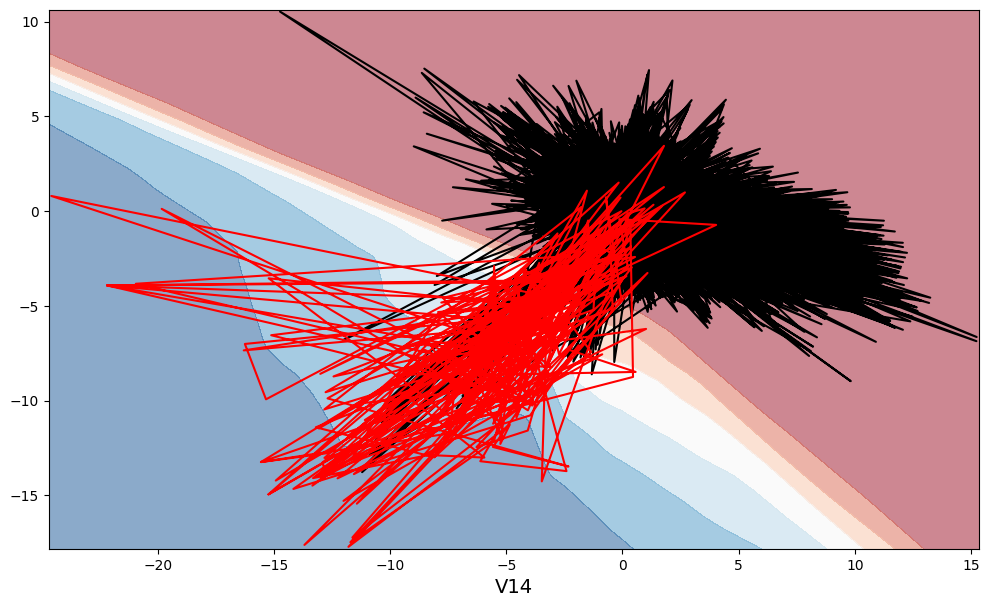

In [51]:
plt.figure(figsize=(12, 7))
plot_ann_decision_boundary(X_train_reduced.values, y_train, model)
plt.show()

Representación de los ejemplos catalogados como maliciosos

In [52]:
# Predicción con el conjunto de datos de entenamiento
y_pred = model.predict(X_train_reduced).round(0)

5341/5341 [==============================] - 11s 2ms/step


31250/31250 [==============================] - 63s 2ms/step


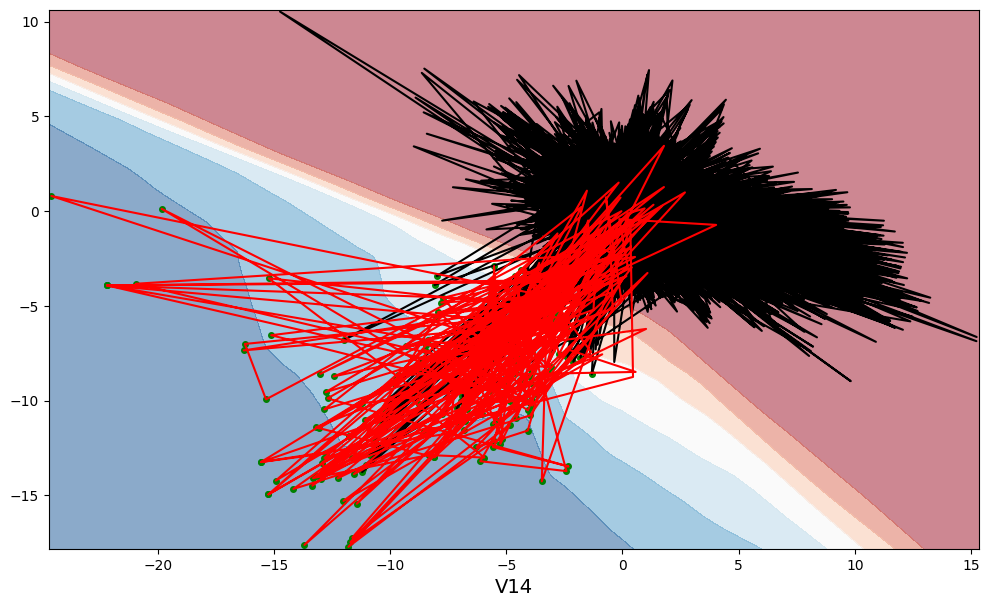

In [53]:
plt.figure(figsize=(12, 7))
plt.plot(X_train_reduced[y_pred==1]["V10"], X_train_reduced[y_pred==1]["V14"], 'go', markersize=4)
plot_ann_decision_boundary(X_train_reduced.values, y_train, model)
plt.show()

Predicción con el conjunto de datos reducido

In [54]:
# Predicción con el conjunto de datos de prueba
y_pred = model.predict(X_test_reduced).round(0)

1781/1781 [==============================] - 4s 2ms/step


In [55]:
print("F1_score:", f1_score(y_test, y_pred))

F1_score: 0.8268156424581005
